In [24]:
import numpy as np
import pandas as pd

import random

from matplotlib import pyplot as plt

import warnings
from sklearn.metrics import pairwise_distances


warnings.filterwarnings('ignore')

In [2]:
import scipy.sparse

In [215]:
matrix = pd.DataFrame({
    'UserId': [1,2,3,4],
    'Category_1': [0,0,2,3],
    'Category_2': [5,3,0,0],
    'Category_3': [1,0,4,7]
})
matrix = matrix.set_index('UserId')

In [216]:
matrix.head()

,Category_1,Category_2,Category_3
UserId,,,
1,0,5,1
2,0,3,0
3,2,0,4
4,3,0,7


In [217]:
y = np.array([0,1,0]).reshape(1,-1)

matrix = matrix.values
matrix

array([[0, 5, 1],
       [0, 3, 0],
       [2, 0, 4],
       [3, 0, 7]], dtype=int64)

In [218]:
y

array([[0, 1, 0]])

In [219]:
dist = pairwise_distances(matrix, y, metric='l2')    
dist = dist.flatten()
dist

array([4.12310563, 2.        , 4.58257569, 7.68114575])

In [220]:
closest = get_close_users(matrix, y, 4, 'euclidean')
closest

array([[0, 3, 0],
       [0, 5, 1],
       [2, 0, 4],
       [3, 0, 7]], dtype=int64)

In [239]:
predict(y, closest)

[2 1 0]


[2, 0]

### Distances

In [3]:
from sklearn.metrics import pairwise_distances

def get_close_users(matrix, new_user, top_n=3, metric='euclidean'):
    dist = pairwise_distances(matrix, new_user.reshape(1,-1), metric=metric)    
    dist = dist.flatten()
    idx = np.argsort(dist)[:top_n]    
    return matrix[idx]

In [4]:
def get_ids(new_user, closest, top_n=2):
    answer = []
    missing = np.where(new_user == 0)
    missing = np.array([x[1] for x in missing])
    columns_max = closest.max(axis=0)
    idx = np.argsort(columns_max)
    unsorted = np.intersect1d(missing, idx)
    buf = np.in1d(idx, missing)[::-1]
    for i,item in enumerate(buf):
        if item == True:
            answer.append(idx[::-1][i])
    
    return answer[:top_n]

In [5]:
def create_anomalies(data, delete_percentage):
    deleted_indexes = []
    anom = data.copy()
    for item in anom:
        n_delete =  delete_percentage
        positions = np.nonzero(item)
        if len(positions[0]) < 2:
            continue
        if n_delete >= len(positions[0]):
            n_delete = len(positions[0]) - 1
        indexes = random.sample(list(positions[0]), k=n_delete)
        item[indexes] = 0
        deleted_indexes.append(indexes)
    return anom, deleted_indexes

### Validation, yeeeeah

In [6]:
matrix = scipy.sparse.load_npz(r'E:\repos\Datathon\deepmenu\data\embedings.npz')

In [7]:
matrix.shape

(3001330, 9746)

In [8]:
train = matrix[:1200].toarray()
test = matrix[1200:1300].toarray()

In [9]:
corrupted, indexes = create_anomalies(test, 2)

In [15]:
from scipy.spatial import distance

In [16]:
def validate(matrix, user, original, metric):
    closest = get_close_users(matrix, user, 3, metric)
    indexes = get_ids(user, closest, 2)
    user[indexes] = 1
    dst = distance.euclidean(user, original)
    return dst

In [17]:
import time
distances = {}
metrics = ['cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']

metrics += ['braycurtis', 'canberra', 'chebyshev', 'correlation', 'hamming','minkowski','seuclidean', 'sqeuclidean']
def check_metrics(train, test, corrupted):
    for metric in metrics:
        dist = 0
        start = time.time()
        print(metric)
        for i, cor_user in enumerate(corrupted):
            val = validate(train, cor_user, test[i], metric)
            dist+=val
        distances[metric] = dist
        print(time.time()-start)

In [18]:
check_metrics(train, test, corrupted)

cityblock
19.995943546295166
cosine
33.5530104637146
euclidean
16.306379318237305
l1
15.987232446670532
l2
15.640161752700806
manhattan
14.320688009262085
braycurtis
18.028803825378418
canberra
14.33165955543518
chebyshev
14.184058666229248
correlation
46.89754056930542
hamming
18.40376615524292
minkowski
78.26466512680054
seuclidean
87.66873335838318
sqeuclidean
27.92031192779541


In [32]:
list(distances.keys())

['cityblock',
 'cosine',
 'euclidean',
 'l1',
 'l2',
 'manhattan',
 'braycurtis',
 'canberra',
 'chebyshev',
 'correlation',
 'hamming',
 'minkowski',
 'seuclidean',
 'sqeuclidean']

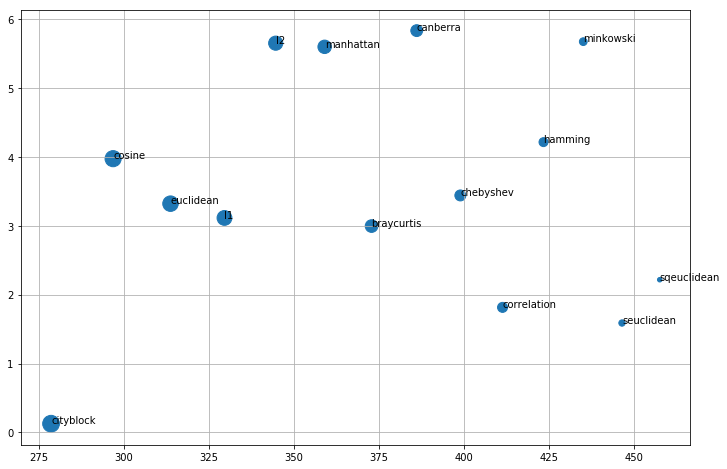

In [48]:
plt.figure(figsize=(12,8))
y = np.random.uniform(0,6, len(distances))
s = [20*n+20 for n in range(len(y))]
s = s[::-1]
plt.scatter(distances.values(), y,s=s)

for i, txt in enumerate(distances):
    plt.annotate(list(distances.keys())[i], (list(distances.values())[i], y[i]))
plt.grid()
plt.show()

In [19]:
distances

{'cityblock': 278.54101966249686,
 'cosine': 296.79562676708355,
 'euclidean': 313.67650693224516,
 'l1': 329.5545360822131,
 'l2': 344.6244419246184,
 'manhattan': 359.0142045583574,
 'braycurtis': 372.8167961072475,
 'canberra': 386.1036598507973,
 'chebyshev': 398.9317191813724,
 'correlation': 411.3475040719934,
 'hamming': 423.3897896281426,
 'minkowski': 435.0913844756556,
 'seuclidean': 446.4803963580517,
 'sqeuclidean': 457.58115802653396}

In [173]:
test = np.array([[1,2,3,4], [0,0,4,3],[5,3,0,0]])
matrix

array([[1, 2, 3, 4],
       [0, 0, 4, 3],
       [5, 3, 0, 0],
       [1, 0, 2, 0]])

In [ ]:
def get_ids(database, user, n_closest, n_items, metric):
    closest = get_close_users(database, user, n_closest, metric)
    indexes = predict(user, closest, n_items)
    return indexes

In [174]:
anomalous_data, deleted_indexs = create_anomalies(matrix, 2)